## Setting Up Environment and Importing Required Modules

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Navigate to the project directory
%cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Import custom modules
from src.utils.utils import read_json, create_mask
from src.dataset.dataset import SegmentationDataset
from src.models.resnetunet import ResNetUNet
from src.utils.transform import transform_img, transform_mask
from src.train import train
from src.utils.loss import DiceLoss

Mounted at /content/drive/
/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


## Loading and Displaying the Initial Rows

In [ ]:
# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'

df = read_json(root_dir)
df.head(2)

Annotation is missing for image 1380 in train


,file_name,width,height,category_id,segmentation,subset
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,1,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",train
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,1,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",train


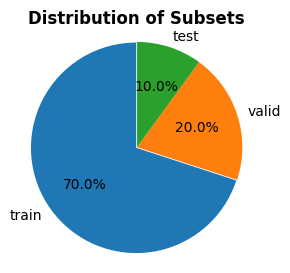

In [ ]:
# Function to plot subset distribution
def plot_subset_distribution(df):
    subset_counts = df['subset'].value_counts()
    explode = (0.01, 0, 0)  # Only "explode" the first slice (slightly)
    plt.figure(figsize=(3, 3))
    plt.pie(subset_counts, labels=subset_counts.index, autopct='%1.1f%%', startangle=90, explode=explode)
    plt.title('Distribution of Subsets', weight='bold')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

# Plot the distribution of subsets
plot_subset_distribution(df)

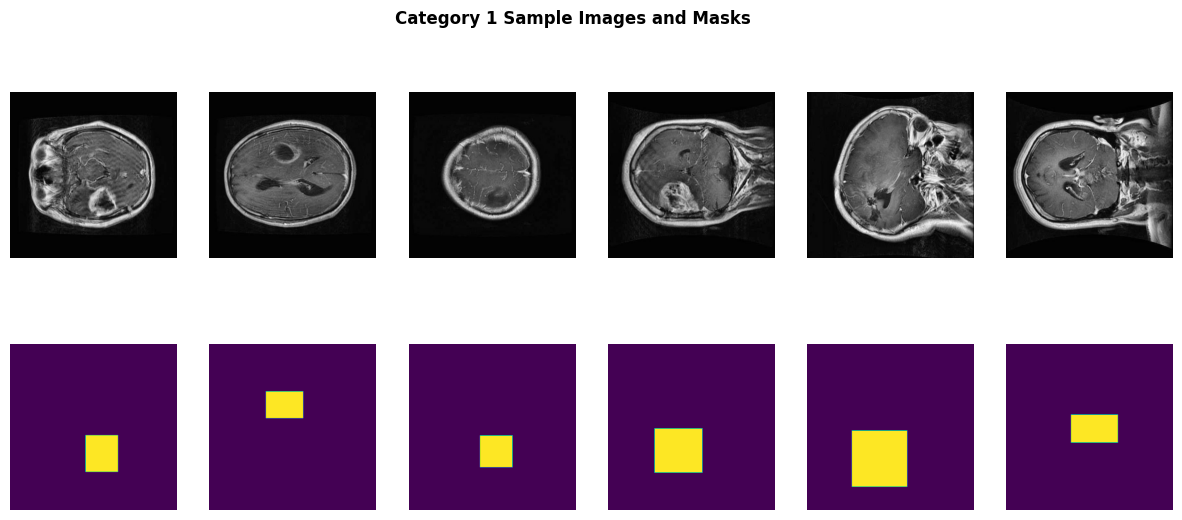

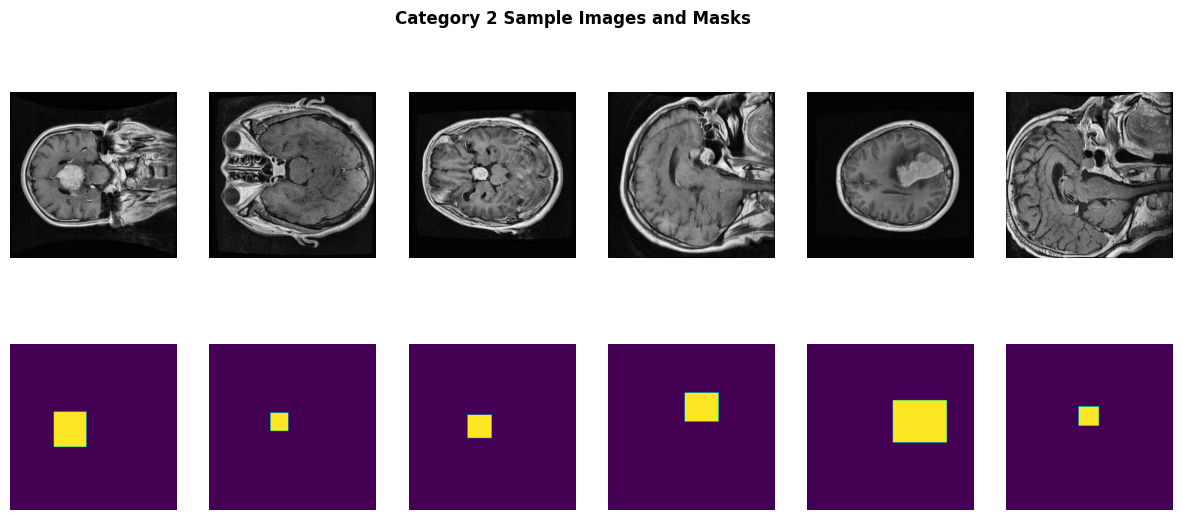

In [ ]:
# Function to plot sample images and masks
def plot_samples(df, root_dir, category_id, title, num_samples=6):
    samp = df[df['category_id'] == category_id].sample(num_samples).reset_index(drop=True)
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    for i in range(num_samples):
        img = mpimg.imread(os.path.join(root_dir, samp.loc[i]['subset'], samp.loc[i]['file_name']))
        axes[0, i].imshow(img)
        axes[0, i].axis('off')  # Turn off axis labels

        mask = create_mask(samp.loc[i])
        axes[1, i].imshow(mask)
        axes[1, i].axis('off')  # Turn off axis labels

    fig.suptitle(title, weight='bold')
    plt.show()

# Plot samples for category 1
plot_samples(df, root_dir, category_id=1, title='Category 1 Sample Images and Masks')

# Plot samples for category 2
plot_samples(df, root_dir, category_id=2, title='Category 2 Sample Images and Masks')


## Defining Transformations and Creating Data Loaders

### Transformation

In [ ]:
# Import necessary libraries
from src.utils.transform import transform_img, transform_mask

# Define transformations for images and masks
transform = {
    'image': transform_img,
    'mask': transform_mask
}

### Data Loader

In [ ]:
# Import necessary libraries
from src.dataset.dataset import SegmentationDataset
from torch.utils.data import DataLoader

# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'

# Load dataset
df = read_json(root_dir)

# Create train and validation dataloaders
# Uncomment and use the train dataloader if needed
# Train dataloader
# train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'train'].reset_index(drop=True), subset='train', max_samp=224, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation dataloader
valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset'] == 'valid'].reset_index(drop=True), subset='valid', max_samp=50, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=25, shuffle=False)


Annotation is missing for image 1380 in train


valid: 100%|██████████| 50/50 [00:00<00:00, 79.30it/s]


## Model Initialization, Loss Function, Optimizer, and Training Configuration

In [ ]:
# Import necessary libraries
import torch.nn as nn
import torch.optim as optim

# Import custom model
from src.models.resnetunet import ResNetUNet

# Initialize the model, loss function, and optimizer
model = ResNetUNet()
criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss.
#criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

# Set the number of epochs and other training parameters
num_epochs = 200
valid_step = 5
ckpt_step = 5
exp_id = 'exp_7'

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model.to(device)

## Training

In [ ]:
train(model,
      optimizer,
      criterion,
      num_epochs,
      train_loader,
      valid_loader,
      ckpt_step,
      valid_step,
      device,
      exp_id,
      resume_ckp = None)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/200], Loss: 0.7250
Average Valid Loss: 0.7228
Epoch [2/200], Loss: 0.7221
Epoch [3/200], Loss: 0.7194
Epoch [4/200], Loss: 0.7168
Epoch [5/200], Loss: 0.7143
Epoch [6/200], Loss: 0.7120
Average Valid Loss: 0.7103
Epoch [7/200], Loss: 0.7096
Epoch [8/200], Loss: 0.7072
Epoch [9/200], Loss: 0.7046
Epoch [10/200], Loss: 0.7019
Epoch [11/200], Loss: 0.6991
Average Valid Loss: 0.6977
Epoch [12/200], Loss: 0.6960
Epoch [13/200], Loss: 0.6926
Epoch [14/200], Loss: 0.6890
Epoch [15/200], Loss: 0.6850
Epoch [16/200], Loss: 0.6807
Average Valid Loss: 0.6783
Epoch [17/200], Loss: 0.6761
Epoch [18/200], Loss: 0.6710
Epoch [19/200], Loss: 0.6655
Epoch [20/200], Loss: 0.6595
Epoch [21/200], Loss: 0.6532
Average Valid Loss: 0.6499
Epoch [22/200], Loss: 0.6465
Epoch [23/200], Loss: 0.6395
Epoch [24/200], Loss: 0.6320
Epoch [25/200], Loss: 0.6242
Epoch [26/200], Loss: 0.6159
Average Valid Loss: 0.6121
Epoch [27/200], Loss: 0.6072
Epoch [28/200], Loss: 0.5978
Epoch [29/200], Loss: 0.5879
Epoch 

In [ ]:
x = torch.randn(1, 3, 640, 640).cuda()  # Batch size 1, single channel image of size 80x80
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 160, 160])


In [ ]:
torch.cuda.empty_cache()

Text(0.5, 0.98, 'Training and Validation Loss Curves')

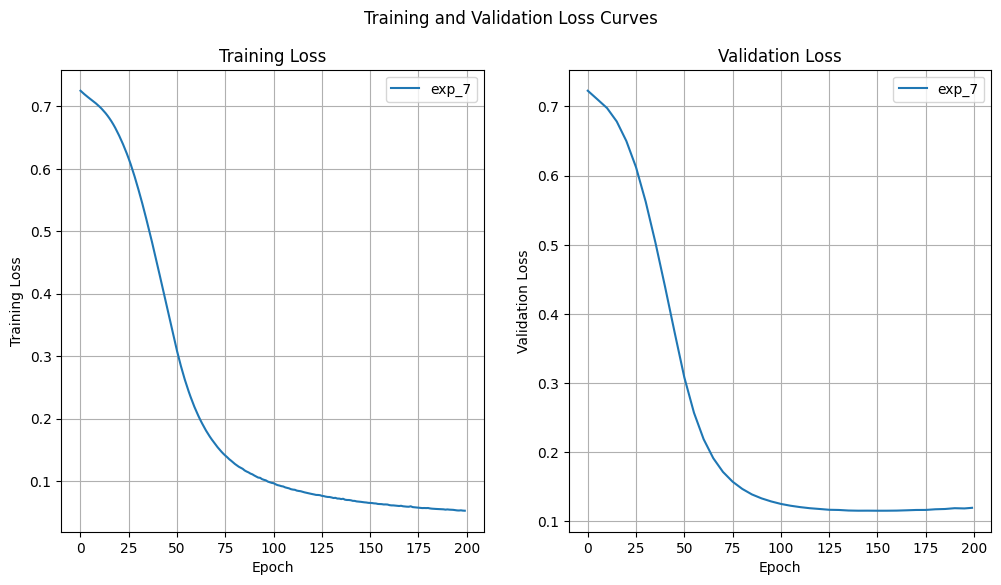

In [ ]:
"""
Plot train and validation curves
"""

exp_ids = ['exp_7']
xlim_ = 5
ylim_ = 0.1

fig, axes = plt.subplots (1,2,figsize=(12,6))

for exp in exp_ids:

  in_path = os.path.join('Model_Checkpoints',exp,'loss_log.npy')
  loss_log = np.load(in_path, allow_pickle=True).item()
  train_loss = loss_log['train']
  valid_loss = loss_log['valid']

  axes[0].plot(np.vstack(train_loss)[:,0],np.vstack(train_loss)[:,1]) #vertically stack the array---- (train_loss) contains elements of [epoch, epoch_loss] --> 10 0utput because we have 10.
  axes[1].plot(np.vstack(valid_loss)[:,0],np.vstack(valid_loss)[:,1])




#axes[0].set_xlim(0, xlim_)
#axes[1].set_xlim(0, xlim_)
#axes[0].set_ylim(0, ylim_)
#axes[1].set_ylim(0, ylim_)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss')
axes[0].grid(True)
axes[1].grid(True)
axes[0].legend(exp_ids)
axes[1].legend(exp_ids)

fig.suptitle('Training and Validation Loss Curves')


In [ ]:
def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [ ]:
model = ResNetUNet()
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNetUNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

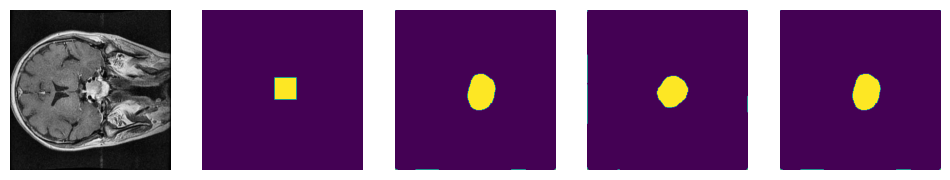

In [ ]:
"""
Visualize sample validation result.
"""

#model = ResNetUNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

idx=49
experiments = ['exp_2', 'exp_5', 'exp_2']
ckps = ['ckp_190.pt', 'ckp_190.pt', 'ckp_190.pt']

mask = valid_dataset.data_[idx]['mask']
mask = valid_dataset.transform['mask'](mask).squeeze(0).numpy()
mask[mask>0] = 1.0

model = ResNetUNet().to(device)

image = valid_dataset.data_[idx]['image']
img = valid_dataset.transform['image'](image)
img = img.unsqueeze(0)
img = img.to(device)

preds = []
iou_val = []
acc_val = []
dice_val = []
prec_val = []
rec_val = []

for i, exp in enumerate(experiments):
  # Load the trained model
  ckp_path = os.path.join('Model_Checkpoints',exp, ckps[i])
  checkpoint = torch.load(ckp_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.eval()
  sigmoid = nn.Sigmoid()  # If the model does not have embedded sigmoid


  with torch.no_grad():
    pred = model(img)
  pred = pred.squeeze(0)
  pred = pred.squeeze(0)
  pred = sigmoid(pred).cpu().numpy()

  thresh=0.2
  pred[pred>thresh]=1.0
  pred[pred<=thresh]=0.0

  preds.append(pred)


  #iou_val.append(iou(mask, pred))
  #acc_val.append(accuracy(mask, pred))
  #dice_val.append(dice_coef(mask, pred))
  #prec_val.append(precision_score_(mask, pred))
  #rec_val.append(recall_score_(mask, pred))


# Plot the image, mask, and prediction
fig, axes = plt.subplots (1,5,figsize=(12,6))


#for exp in experiments:
 # print('{s} -- IoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}\n'.format(exp,iou_val,acc_val,dice_val,prec_val,rec_val))


axes[0].imshow(image)
axes[1].imshow(mask)
axes[2].imshow(preds[0])
axes[3].imshow(preds[1])
axes[4].imshow(preds[2])

for i in range(5):
  axes[i].axis('off')


In [ ]:

# Load the trained model
ckp_path = os.path.join('Model_Checkpoints','exp_7','ckp_190.pt')
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sigmoid = nn.Sigmoid()  # If the model does not have embedded sigmoid

thresh=0.2   #convert prediction from probability into a category

iou_val = []
acc_val = []
dice_val = []
prec_val = []
rec_val = []

for idx in tqdm(range(valid_dataset.__len__())):

  image = valid_dataset.data_[idx]['image']
  mask = valid_dataset.data_[idx]['mask']

  mask = valid_dataset.transform['mask'](mask).squeeze(0).numpy()
  mask[mask>0] = 1.0

  img = valid_dataset.transform['image'](image)
  img = img.unsqueeze(0)
  img = img.to(device)
  with torch.no_grad():
    pred = model(img)
  pred = pred.squeeze(0)
  pred = pred.squeeze(0)
  pred = sigmoid(pred).cpu().numpy()


  pred[pred>thresh]= 1.0
  pred[pred<=thresh]= 0.0

  iou_val.append(iou(mask, pred))
  acc_val.append(accuracy(mask, pred))
  dice_val.append(dice_coef(mask, pred))
  prec_val.append(precision_score_(mask, pred))
  rec_val.append(recall_score_(mask, pred))

iou_val = np.mean(iou_val)
acc_val = np.mean(acc_val)
dice_val = np.mean(dice_val)
prec_val = np.mean(prec_val)
rec_val = np.mean(rec_val)

print('\nIoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}'.format(iou_val,acc_val,dice_val,prec_val,rec_val))


100%|██████████| 50/50 [00:00<00:00, 139.02it/s]


IoU:0.33, Acc:0.96, Dice:0.44, Precision:0.49, Recall:0.50
